In [ ]:
import os
import scipy
import numpy as np
import pandas as pd
import random as rand
import matplotlib.pyplot as plt
from sklearn import svm
from sklearn.metrics import confusion_matrix, roc_auc_score, roc_curve
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler


## Importing Data

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

path = os.path.join(os.getcwd(), "drive", "MyDrive","ORIE 5741 Final Project", "Data")
bookings = pd.read_csv(os.path.join(path, "processed_hotel_bookings.csv"))
# bookings = pd.read_csv("processed_hotel_bookings.csv")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
bookings

,Unnamed: 0,is_canceled,lead_time,arrival_date_year,arrival_date_month,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,...,assigned_room_type_I,assigned_room_type_K,assigned_room_type_P,deposit_type_No Deposit,deposit_type_Non Refund,deposit_type_Refundable,customer_type_Contract,customer_type_Group,customer_type_Transient,customer_type_Transient-Party
0,8030,1,238,2016,9,37,7,0,3,1,...,0,0,0,0,1,0,0,0,1,0
1,37532,0,33,2017,6,25,19,1,1,2,...,0,0,0,1,0,0,0,0,1,0
2,76865,1,239,2015,10,42,17,0,1,2,...,0,0,0,0,1,0,0,0,1,0
3,1960,0,64,2015,9,39,24,0,3,2,...,0,0,0,1,0,0,0,0,1,0
4,98971,0,34,2016,10,41,2,2,3,2,...,0,0,0,1,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
23770,101117,0,44,2016,11,45,1,0,5,2,...,0,0,0,1,0,0,0,0,1,0
23771,84909,0,39,2016,3,10,4,0,2,1,...,0,0,0,1,0,0,0,0,0,1
23772,99765,0,10,2016,10,42,13,1,3,3,...,0,0,0,1,0,0,0,0,1,0
23773,62196,1,33,2017,1,1,4,0,4,1,...,0,0,0,1,0,0,0,0,1,0


## Processing Data

In [ ]:
X = bookings.iloc[:, 2:]
y = bookings.iloc[:, 1]

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [ ]:
# standardizing numeric columns and one-hot encoding categorical variables since algorithms are sensitive to scale
numerical_cols = ['lead_time', 'stays_in_weekend_nights',
                'stays_in_week_nights', 'adults', 'children', 'babies',
                'previous_cancellations', 'previous_bookings_not_canceled', 
                'booking_changes', 'days_in_waiting_list', 'adr',
                'required_car_parking_spaces', 'total_of_special_requests']
                
for n in numerical_cols:
    scalar = StandardScaler()
    scalar.fit(np.array(X_train[n]).reshape(-1, 1))
    X_train[n] = scalar.transform(np.array(X_train[n]).reshape(-1, 1)).reshape(-1, 1)
    X_test[n] = scalar.transform(np.array(X_test[n]).reshape(-1, 1)).reshape(-1, 1)

## SVM

In [ ]:
C = [0.01, 0.1, 1, 10]
kernel = ['poly', 'rbf']
param_grid = {'C': C, 'kernel':kernel}

In [ ]:
model = svm.SVC()
model_grid = RandomizedSearchCV(estimator = model, param_distributions = param_grid, n_iter = 100, cv = 3, verbose=2, random_state=42, n_jobs = -1)
model_grid.fit(X_train, y_train)

Fitting 3 folds for each of 8 candidates, totalling 24 fits


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_search.py:305: UserWarning: The total space of parameters 8 is smaller than n_iter=100. Running 8 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


RandomizedSearchCV(cv=3, estimator=SVC(), n_iter=100, n_jobs=-1,
                   param_distributions={'C': [0.01, 0.1, 1, 10],
                                        'kernel': ['poly', 'rbf']},
                   random_state=42, verbose=2)

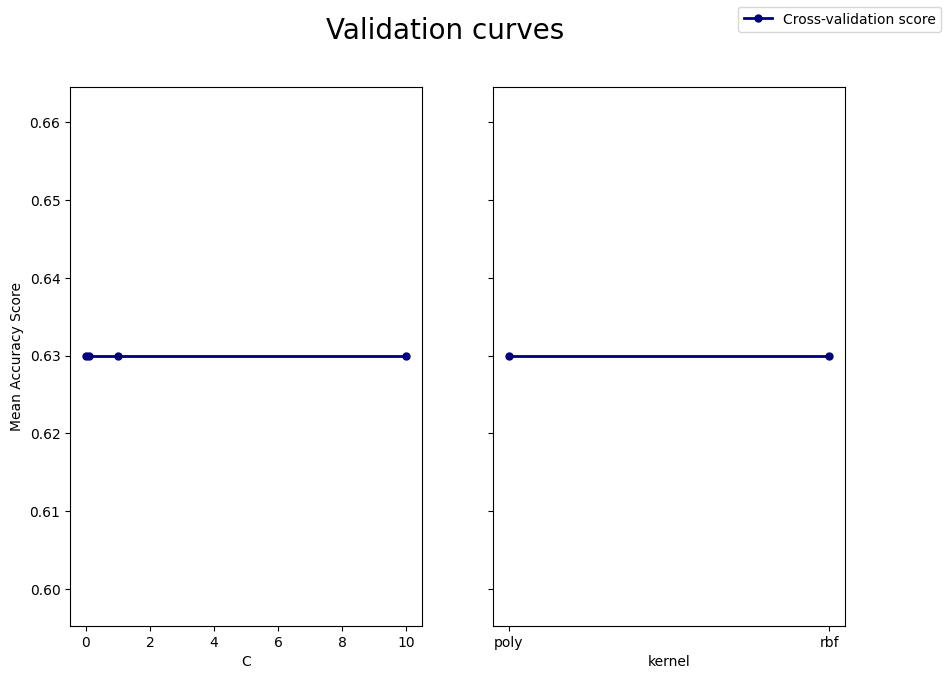

In [ ]:
# graphing parameters and associated validation error
df = pd.DataFrame(model_grid.cv_results_)
results = ['mean_test_score',
           'std_test_score']
           
fig, axes = plt.subplots(1, len(param_grid), 
                         figsize = (5*len(param_grid), 7),
                         sharey='row')
axes[0].set_ylabel("Mean Accuracy Score", fontsize=10)


for idx, (param_name, param_range) in enumerate(param_grid.items()):
    grouped_df = df.groupby(f'param_{param_name}')[results]\
        .agg({'mean_test_score': 'mean',
              'std_test_score': 'std'})
    # previous_group = df.groupby(f'param_{param_name}')[results]
    axes[idx].set_xlabel(param_name, fontsize=10)
    lw = 2
    axes[idx].plot(param_range, grouped_df['mean_test_score'], label="Cross-validation score",
                color="navy", lw=lw, marker ='o', ms=5)
    axes[idx].fill_between(param_range, grouped_df['mean_test_score'] - grouped_df['std_test_score'],
                    grouped_df['mean_test_score'] + grouped_df['std_test_score'], alpha=0.2,
                    color="navy", lw=lw)

handles, labels = axes[0].get_legend_handles_labels()
fig.suptitle('Validation curves', fontsize=20)
fig.legend(handles, labels, fontsize=10)
 
plt.show();

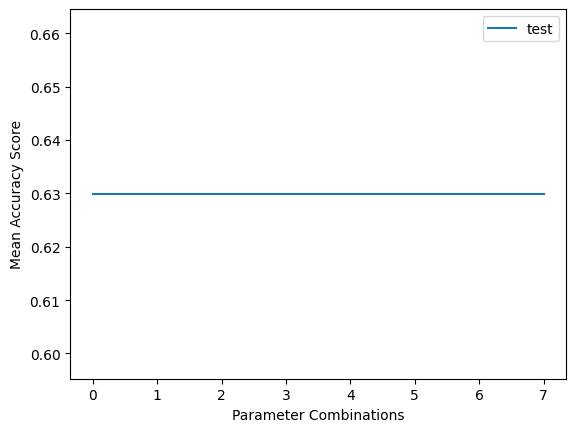

In [ ]:
test_scores = model_grid.cv_results_['mean_test_score'] 

plt.plot(test_scores, label='test')
plt.xlabel('Parameter Combinations')
plt.ylabel('Mean Accuracy Score')
plt.legend(loc='best')
plt.show()

In [ ]:
model_grid.cv_results_

{'mean_fit_time': array([25.89679774, 23.40111883, 22.0376602 , 24.14565865, 24.74208903,
        24.54174829, 23.86516086, 22.04263099]),
 'std_fit_time': array([3.37404777, 3.40014   , 2.59332389, 1.28396289, 0.68911932,
        1.38210002, 0.2880472 , 3.76346487]),
 'mean_score_time': array([ 8.21185064, 24.78776042,  8.26588726, 23.0802083 ,  6.12569539,
        22.82595865,  6.79584821, 19.04831441]),
 'std_score_time': array([0.27508386, 2.66246266, 0.34806154, 0.33531779, 0.41394348,
        0.61837224, 1.25886242, 4.71018047]),
 'param_kernel': masked_array(data=['poly', 'rbf', 'poly', 'rbf', 'poly', 'rbf', 'poly',
                    'rbf'],
              mask=[False, False, False, False, False, False, False, False],
        fill_value='?',
             dtype=object),
 'param_C': masked_array(data=[0.01, 0.01, 0.1, 0.1, 1, 1, 10, 10],
              mask=[False, False, False, False, False, False, False, False],
        fill_value='?',
             dtype=object),
 'params': [{'k

In [ ]:
# printing best params and validation score
print(model_grid.best_params_)
print(model_grid.best_score_)

{'kernel': 'poly', 'C': 0.01}
0.6299122674874607


In [ ]:
# testing best svm model
# getting confusion matrix: rows are actual values, columns are predicted
y_pred_probs = model_grid.predict(X_test)
y_pred = np.round(y_pred_probs)
cm = confusion_matrix(y_test, y_pred)
pd.DataFrame(cm)

,0,1
0,4529,0
1,2604,0


In [ ]:
# not canceling is positive
# canceling is negative
accuracy = (cm[0][0] + cm [1][1]) / np.sum(cm)
precision = (cm[0][0]) / np.sum(cm[0, :])
recall = (cm[0][0]) / np.sum(cm[:, 0])
f1 = 2 * (precision * recall) / (precision + recall)
print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1:", f1)

Accuracy: 0.634936211972522
Precision: 1.0
Recall: 0.634936211972522
F1: 0.7767106842737095


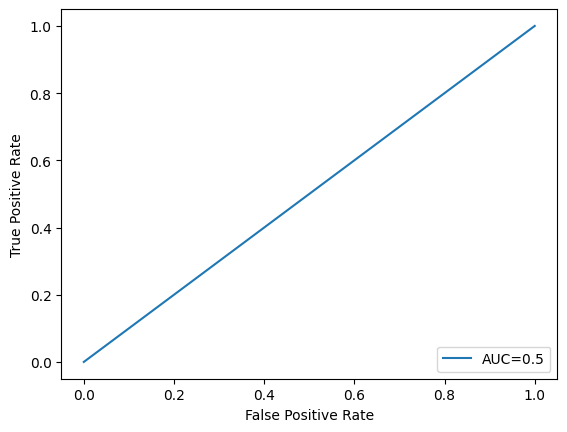

In [ ]:
fpr, tpr, _ = roc_curve(y_test,  y_pred_probs)
auc = roc_auc_score(y_test, y_pred_probs)

#create ROC curve
plt.plot(fpr,tpr,label="AUC="+str(auc))
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.legend(loc=4)
plt.show()